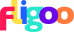

<hr>
<p style="font-size:40px;text-align:center">Take Home - Data Science</p>
<hr>

# The Hotel Bookings Data
Let’s use hotel bookings data from [Antonio, Almeida, and Nunes (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191?via%3Dihub) to predict which hotel stays included children and/or babies, based on the other characteristics of the stays such as which hotel the guests stay at, how much they pay, etc.

<img src="https://s3-us-west-2.amazonaws.com/fligoo.data-science/TechInterviews/HotelBookings/header.png"/>

One of the hotels (H1) is a resort hotel and the other is a city hotel (H2). Both datasets share the same structure, with 23 variables describing the 19248 observations of H1 and 30752 observations of H2. Each observation represents a hotel booking. Both datasets comprehend bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017, including bookings that effectively arrived and bookings that were canceled. Since this is hotel real data, all data elements pertaining hotel or custumer identification were deleted.

**Take-Home Goals**

#### Part 1
During **Part I**, you should perform an Exploratory Data Analysis highlighting key findings:
  - Data Quality Check: You must check the quality of the given dataset to make an assessment of how appropriate it is for later Data Science tasks. Propose a set of corrective actions over the data if any.
  - Report insights and conclusions: Describe the results obtained during the exploratory analysis and provide conclusions from a business perspective, supported by plots / tables / metrics.
  - **Expected**:
    - Make at least 10 plots with any ploting library (plotly, matplotlib, seaborn, etc.)
    - Write down the conclusions, in a clear manner, of every plot in this notebook

#### Part 2
In **Part II** you should define and train a model to predict which actual hotel stays included children/babies, and which did not:
  - **Feature extraction:** Indicate some possible candidates of features that could properly describe the hotels, either from the given columns or from their transformations.
      - **Expected**:
        - Create **one** scikit-learn pipeline inside a file called `pipelines.py`
        - Create at least **three** scikit-learn transformers inside a file called `transformers.py` and use them inside the pipeline from previous step. This transformers should add new features or clean the original dataframe of this take-home
          - Feature example: Compute "total_nights" feature. This is the sum of `stays_in_week_nights` + `stays_in_weekend_nights`
          - Cleaning example: Transform string values. `'0'` to int type `0` 
        - Import pipeline and run the transformations inside this notebook

  - **Machine Learning modeling:** Fit models with the given data. Pay attention to the entire process to avoid missing any crucial step. You could use the `children` column as target.
    - **Expected**:
      - Use the dataset with the new features generated to train *at least* **three** different machine learning models and generate metrics about their performance.
    
#### Part 3
Finally, on **Part III** you should present the key findings, conclusions and results to non-technical stakeholders.
  - **Expected**:
    - Create a summary of all the findings in part 1
    - Create an explanation of the features added in part 2
    - Create a summary of the model metrics
    - These explanations should be at high level and understood by a non-technical person
    - You can add all the summaries and explanations at the end of this notebook, it can be done in markdown format or any other external resource like a ppt presentation, pdf document, etc. Whatever works best for you!

 
**Requirements**
- Python 3.x & Pandas 1.x
- Paying attention to the details and narrative is far way more important than extensive development.
- Once you complete the assessment, please send a ZIP file of the folder with all the resources used in this work (e.g. Jupyter notebook, Python scripts, text files, images, etc) or share the repository link.
- Virtualenv, requirements or Conda environment for isolation.
- Have a final meeting with the team to discuss the work done in this notebook and answer the questions that could arise.
- Finally, but most important: Have fun!

**Nice to have aspects**
- Code versioning with Git (you are free to publish it on your own Github/Bitbucket account!).
- Show proficiency in Python: By showing good practices in the structure and documentation, usage of several programming paradigms (e.g. imperative, OOP, functional), etc.
- Shap Model explanability: explain feature importance with the use of shapley values

## Part I - Exploratory Data Analisys

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Pipelines
from sklearn.pipeline import Pipeline
#Preprocesamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.feature_selection import SelectorMixin
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer

from sklearn import set_config
set_config(transform_output="pandas")
pd.set_option('display.max_columns', None)


from sklearn.model_selection import train_test_split
#Modelado
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import shap

from sklearn.metrics import classification_report, confusion_matrix

In [8]:

# from pipelines import <your_pipeline_name>

hotels = pd.read_csv('https://s3-us-west-2.amazonaws.com/fligoo.data-science/TechInterviews/HotelBookings/hotels.csv')

In [9]:
hotels

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_date
0,City_Hotel,217,1,3,2,none,BB,DEU,Offline_TA/TO,TA/TO,0,0,0,A,A,0,No_Deposit,0,Transient-Party,80.75,none,1,2016-09-01
1,City_Hotel,2,0,1,2,none,BB,PRT,Direct,Direct,0,0,0,D,K,0,No_Deposit,0,Transient,170.00,none,3,2017-08-25
2,Resort_Hotel,95,2,5,2,none,BB,GBR,Online_TA,TA/TO,0,0,0,A,A,2,No_Deposit,0,Transient,8.00,none,2,2016-11-19
3,Resort_Hotel,143,2,6,2,none,HB,ROU,Online_TA,TA/TO,0,0,0,A,A,0,No_Deposit,0,Transient,81.00,none,1,2016-04-26
4,Resort_Hotel,136,1,4,2,none,HB,PRT,Direct,Direct,0,0,0,F,F,0,No_Deposit,0,Transient,157.60,none,4,2016-12-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Resort_Hotel,172,0,2,2,children,BB,PRT,Direct,Direct,0,0,0,A,A,1,No_Deposit,0,Transient,73.39,none,1,2016-10-07
49996,Resort_Hotel,48,0,4,2,none,FB,PRT,Direct,Direct,0,0,0,A,B,2,No_Deposit,0,Transient,158.00,none,0,2015-09-01
49997,City_Hotel,155,0,4,2,none,BB,DEU,Offline_TA/TO,TA/TO,0,0,0,A,A,0,No_Deposit,0,Transient,82.50,none,1,2017-07-26
49998,Resort_Hotel,140,2,5,2,none,HB,GBR,Direct,Direct,0,0,0,G,G,0,No_Deposit,0,Transient,143.00,none,0,2016-04-28


In [13]:
# Nos quedamos solo con usuarios que efectivamente se hospedaron en el hotel, si las variables stays_in_weekend_nights y stays_in_week_nights estás ambas en cero
# podemos asumir que no se quedaron realmente en el hotel
hotels = hotels[(hotels.stays_in_weekend_nights!=0) | (hotels.stays_in_week_nights!=0)].copy()

In [14]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49552 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           49552 non-null  object        
 1   lead_time                       49552 non-null  int64         
 2   stays_in_weekend_nights         49552 non-null  int64         
 3   stays_in_week_nights            49552 non-null  int64         
 4   adults                          49552 non-null  int64         
 5   children                        49552 non-null  object        
 6   meal                            49552 non-null  object        
 7   country                         49266 non-null  object        
 8   market_segment                  49552 non-null  object        
 9   distribution_channel            49552 non-null  object        
 10  is_repeated_guest               49552 non-null  int64         
 11  pr

In [15]:
# Seteamos arrival_date en formato fecha para trabajar mejor con ella
# Creamos una nueva variable para indicar el mes y año de la estadia
hotels["arrival_date"] =pd.to_datetime(hotels.arrival_date)

hotels["month_visit"] = hotels['arrival_date'].dt.strftime('%Y-%m')

In [16]:
hotels.describe(datetime_is_numeric=True)

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,average_daily_rate,total_of_special_requests,arrival_date
count,49552.000000,49552.000000,49552.000000,49552.000000,49552.000000,49552.000000,49552.000000,49552.000000,49552.000000,49552.000000,49552.000000,49552
mean,80.559917,0.936915,2.486822,1.832640,0.039615,0.016770,0.203261,0.295124,1.584598,100.845922,0.714340,2016-08-25 23:13:07.536325632
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,2015-07-01 00:00:00
25%,9.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.000000,0.000000,2016-03-08 00:00:00
50%,46.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.315000,1.000000,2016-08-30 00:00:00
75%,126.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.100000,1.000000,2017-03-11 00:00:00
max,709.000000,19.000000,50.000000,4.000000,1.000000,13.000000,72.000000,21.000000,379.000000,510.000000,5.000000,2017-08-31 00:00:00
std,91.300715,0.996845,1.930611,0.506603,0.195055,0.288878,1.808822,0.740163,14.856253,48.326504,0.834387,NaN


In [17]:
hotels.describe(include="object")

,hotel,children,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,required_car_parking_spaces,month_visit
count,49552,49552,49552,49266,49552,49552,49552,49552,49552,49552,49552,49552
unique,2,2,5,154,7,5,9,10,3,4,2,26
top,City_Hotel,none,BB,PRT,Online_TA,TA/TO,A,A,No_Deposit,Transient,none,2016-10
freq,30551,45535,37975,13662,23566,38058,34558,27206,49391,34962,44581,2424


In [18]:
print("Distribución de niños en general")
print(hotels.children.value_counts(normalize=True))
print()
print("#############")
print("Distribución de niños por hotel")
print("City Hotel")
print(hotels.children[hotels.hotel=="City_Hotel"].value_counts(normalize=True))
print()
print("Resort Hotel")
print(hotels.children[hotels.hotel=="Resort_Hotel"].value_counts(normalize=True))

Distribución de niños en general
none        0.918934
children    0.081066
Name: children, dtype: float64

#############
Distribución de niños por hotel
City Hotel
none        0.922785
children    0.077215
Name: children, dtype: float64

Resort Hotel
none        0.912741
children    0.087259
Name: children, dtype: float64


Existe una pequeña diferencia entre el porcentaje de huespedes con hijos que prefieren el Resort Hotel sobre el City Hotel

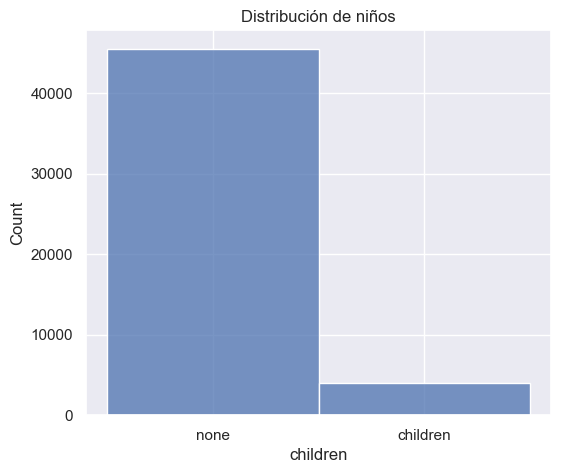

In [19]:
fig, axes = plt.subplots(figsize=(6, 5))
sns.histplot(data=hotels, x = "children")
plt.title('Distribución de niños')
plt.show()

Se puede observar que la variable que va a ser usada como target "children" está desbalanceada, la clase positiva a predecir representa cerca del 8% del total del dataset, por lo que representa un reto a la hora de entrenar el modelo.

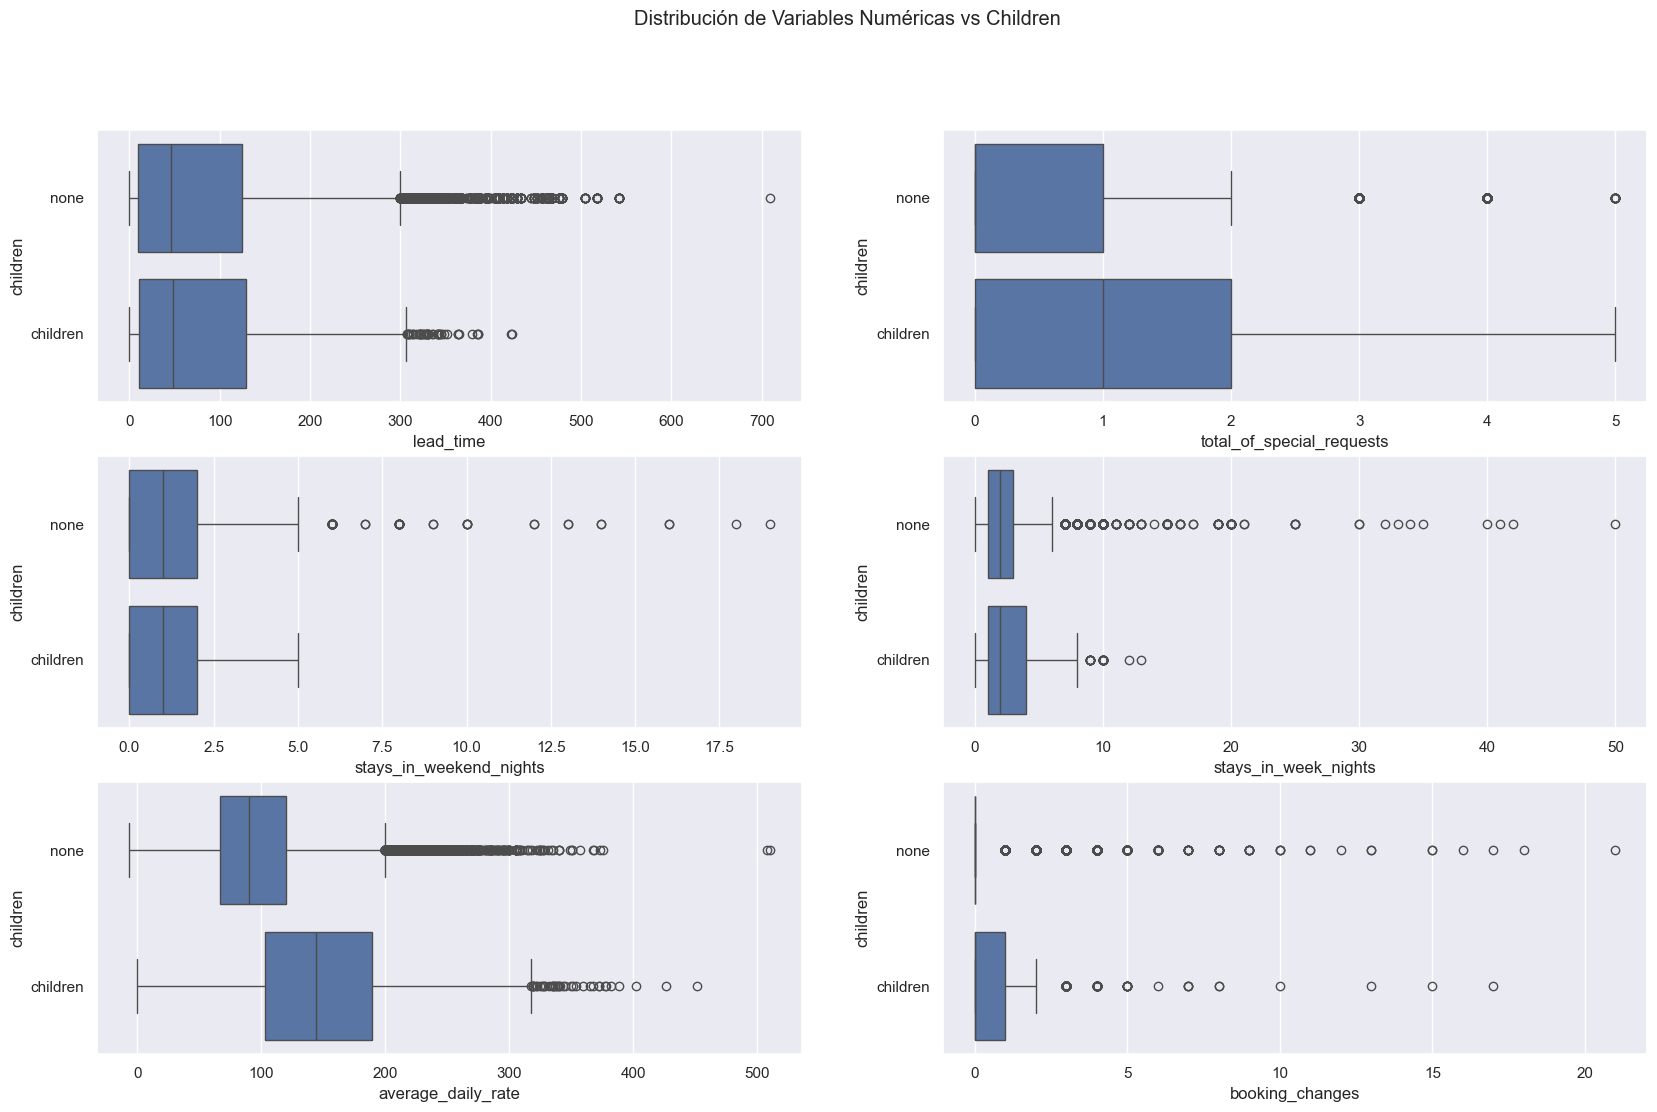

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(data=hotels, x="lead_time", y="children", ax=axes[0,0])
sns.boxplot(data=hotels, x="total_of_special_requests", y="children", ax=axes[0,1])
sns.boxplot(data=hotels, x="stays_in_weekend_nights", y="children", ax=axes[1,0])
sns.boxplot(data=hotels, x="stays_in_week_nights", y="children", ax=axes[1,1])
sns.boxplot(data=hotels, x="average_daily_rate", y="children", ax=axes[2,0])
sns.boxplot(data=hotels, x="booking_changes", y="children", ax=axes[2,1])


fig.suptitle('Distribución de Variables Numéricas vs Children')

plt.show()

* Las variables lead_time y stays_in_weekend_nights tienen identicas distribuciones para usuarios con o sin hijos por lo que no van a ser útiles por si solas a la hora de hacer una clasificación.
* Los usuarios con hijos tienen un promedio más alto para la mayoría de las variables numéricas. Tienden a tener más peticiones especiales, hacen más cambios en la reserva, dejan un promedio de calificación diario superior y tienden a hospedarse en noches durante los días de semana con mayor frecuencia que aquellos huespedes que no tienen hijos.

In [21]:
hotels[["children","assigned_room_type"]].value_counts()

children  assigned_room_type
none      A                     26233
          D                     11728
          E                      3592
          F                      1194
children  A                       973
none      B                       928
          C                       918
children  D                       784
          F                       627
          G                       607
none      G                       563
children  C                       371
          E                       305
          H                       179
          B                       148
none      H                       131
          I                       131
          K                       117
children  I                        17
          K                         6
dtype: int64

In [22]:
hotels[["children","reserved_room_type"]].value_counts()

children  reserved_room_type
none      A                     33042
          D                      8153
          E                      2801
children  A                      1516
none      F                       668
children  F                       620
          G                       553
          D                       464
none      B                       352
          G                       334
children  C                       291
          E                       268
          H                       171
          B                       134
none      C                       122
          H                        61
          L                         2
dtype: int64

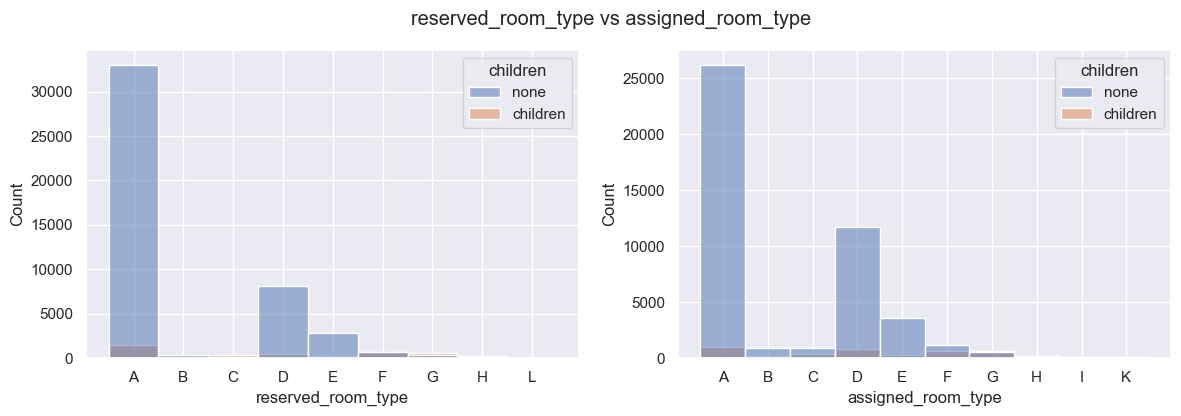

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(data=hotels.sort_values("reserved_room_type"), x = "reserved_room_type",  hue="children", ax=axes[0])
sns.histplot(data=hotels.sort_values("assigned_room_type"), x = "assigned_room_type",  hue="children", ax=axes[1])

fig.suptitle('reserved_room_type vs assigned_room_type')
plt.show()

* La habitación g parece ser preferida por personas con hijos por lo que puede ser un buen clasificador
* Los tipos de habitaciones I y K no fueron reservadas pero aun asi fueron asignadas
* El tipo de habitación L no le fue asignada a nadie a pesar de ser reservada

In [24]:

# Cantidad de huespedes por mes en general
guestsbymonth =  hotels.groupby("month_visit").agg(
     quant_guests_g=('month_visit', 'count'),
     avg_month_rate_g=('average_daily_rate', 'mean')
).reset_index()

# Cantidad de huespedes con o sin hijos
childrenbymonth =  hotels.groupby(["month_visit", "children"]).agg(
     quant_guests=('month_visit', 'count'),
     avg_month_rate=('average_daily_rate', 'mean')
).reset_index()

# Separando a los huespedes sin hijos
no_children = (childrenbymonth[childrenbymonth["children"]== "none"]
               .copy()
               .rename(columns={"quant_guests": "quant_guests_nc", "avg_month_rate": "avg_month_rate_nc"})
               .drop(columns="children"))

# Separando a los huespedes con hijos
children = (childrenbymonth[childrenbymonth["children"]== "children"]
            .copy()
            .rename(columns={"quant_guests": "quant_guests_c", "avg_month_rate": "avg_month_rate_c"})
            .drop(columns="children"))


# Uniendo todo en un solo Datframe
guestsbymonth = guestsbymonth.merge(children, how="left", on="month_visit").merge(no_children, how="left", on="month_visit")
# Creando porcentaje de huespedes con y sin hijos en relación al total de cada mes
guestsbymonth["perc_guests_children"] = (guestsbymonth["quant_guests_c"] / guestsbymonth["quant_guests_g"]).round(2)
guestsbymonth["perc_guests_nochildren"] = (guestsbymonth["quant_guests_nc"] / guestsbymonth["quant_guests_g"]).round(2)
guestsbymonth

,month_visit,quant_guests_g,avg_month_rate_g,quant_guests_c,avg_month_rate_c,quant_guests_nc,avg_month_rate_nc,perc_guests_children,perc_guests_nochildren
0,2015-07,974,110.338152,97,152.613608,877,105.662303,0.10,0.90
1,2015-08,1490,115.814336,174,154.845115,1316,110.653731,0.12,0.88
2,2015-09,2006,98.485892,77,136.267922,1929,96.977745,0.04,0.96
3,2015-10,2124,81.444793,78,105.462692,2046,80.529154,0.04,0.96
4,2015-11,1217,59.682260,40,75.205250,1177,59.154715,0.03,0.97
5,2015-12,1270,72.416638,92,96.747065,1178,70.516469,0.07,0.93
6,2016-01,1142,63.025849,46,80.190652,1096,62.305429,0.04,0.96
7,2016-02,1667,69.426233,129,101.443023,1538,66.740819,0.08,0.92
8,2016-03,2212,75.461433,161,111.371988,2051,72.642516,0.07,0.93
9,2016-04,2203,87.243749,143,129.933497,2060,84.280335,0.06,0.94


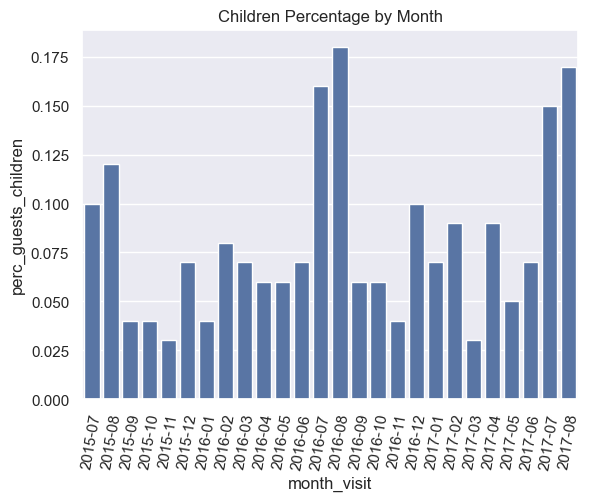

In [25]:

sns.barplot(data=guestsbymonth, x="month_visit", y="perc_guests_children", )
plt.xticks(rotation=80)
plt.title("Children Percentage by Month")
plt.show()

Se puede Observar que el porcentaje de huespedes con niños aumenta en los meses de julio y agosto, lo cual coincide con las vacaciones de verano de los niños en las escuelas, por lo que un buen predictor para el modelo podría ser una variable que indique si los huespues se quedaron esos meses del año.

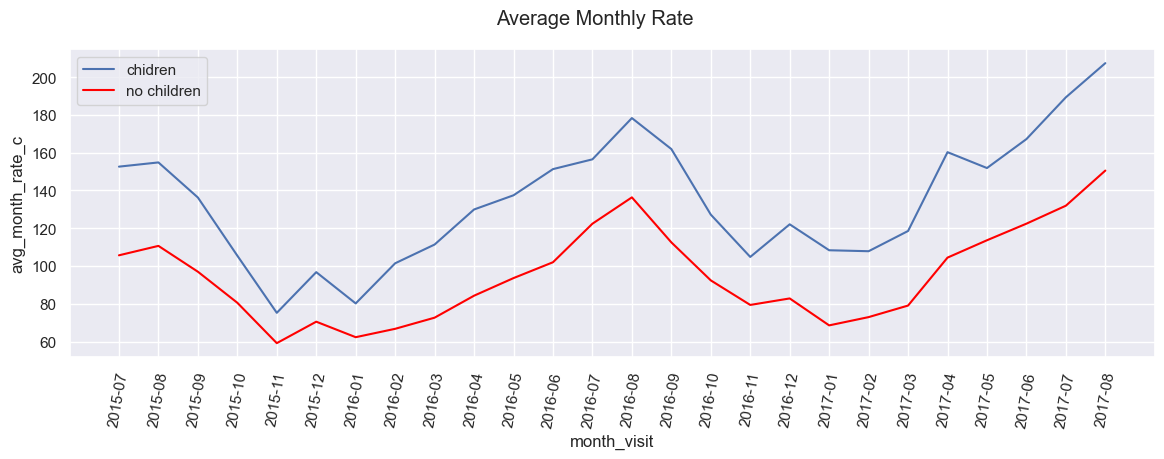

In [26]:
fig, axes = plt.subplots( figsize=(14, 4))

sns.lineplot(data=guestsbymonth,x = "month_visit", y = "avg_month_rate_c",  label="chidren")
sns.lineplot(data=guestsbymonth, x = "month_visit"  , y = "avg_month_rate_nc", color = "red", label="no children")
plt.xticks(rotation=80)
fig.suptitle('Average Monthly Rate')
plt.show()

Usuarios con hijos tienen en promedio un Average Daily Rate superior a aquellos que no tienen hijos, y esto se sostiene a lo largo de los meses porque en ningún momento las líneas se intersectan. Los Meses con mayor Average Daily Rate coinciden con los meses de las vacaciones de verano donde se hospedan más  huespedes con hijos, por lo que debe deberse a actividades especiales en esos meses que aumentan el valor percibido para ambos tipos de huespedes, tanto para los que tienen hijos como para los que no.

## Part II - Modeling

We will build the best model to predict which actual hotel stays included children/babies, and which did not:

In [38]:
#Creando una nueva variable para representar la estacionalidad de las vacaciones
summer = [7,8]
hotels["summer_vacations"] = np.where(hotels["arrival_date"].dt.month.isin(summer), "summer_vacation","none")
hotels.drop(columns=["arrival_date", "month_visit"], inplace=True)

In [51]:
X= hotels.drop(columns="children")
y= np.where(hotels.children=="children",1,0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [75]:
class CorrelationThreshold(SelectorMixin, BaseEstimator):
    "Clase para selección de variables por umbral de correlación."
    
    def __init__(
            self, 
            threshold: bool = 0.9 #Umbral de correlación
            ):
        self.threshold = threshold

    def fit(self, X, y=None):
        df_ = pd.DataFrame(X).copy()
        
        corr_mat_np = pd.DataFrame(
            np.corrcoef(df_.values, rowvar=False), 
            columns=df_.columns, 
            index=df_.columns
        )

        corr_matrix = np.absolute(corr_mat_np)
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        upper = pd.DataFrame(upper)
        self.to_drop = [
            column for column in upper.columns if any(upper[column] > self.threshold)
        ]
        self.seleccion = list(set(pd.DataFrame(X).columns) - set(self.to_drop))
        self.columnas = df_.columns
        return self

    def _get_support_mask(self):
        seleccion_vars = [i in self.seleccion for i in self.columnas]
        return np.array(seleccion_vars)

In [99]:
UMBRAL_CORRELACION = 0.9
UMBRAL_VARIANZA = 0.05
MIN_FRECUENCIA = 0.05
categorical_high_dim = ["country"]
categorical_columns = X_train.select_dtypes(["object"]).drop(columns="country").columns.to_list()
numeric_columns = X_train.select_dtypes(["int", "float"]).columns.to_list()


numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
    ('correlation_threshold', CorrelationThreshold(threshold=UMBRAL_CORRELACION))  
])

non_numeric_transformer = Pipeline(
[
    ("imputation_na", SimpleImputer(
        missing_values=np.nan, strategy="most_frequent", add_indicator=True)),
    ("imputation_none", SimpleImputer(
        missing_values= None, strategy="most_frequent", add_indicator=True)),    
    ("ohe", OneHotEncoder(
        handle_unknown="infrequent_if_exist",
        min_frequency=MIN_FRECUENCIA, drop="if_binary", sparse_output= False )),
    ("varianza", VarianceThreshold(threshold=UMBRAL_VARIANZA))
]
)

non_numeric_hihgdimensionality_transformer = Pipeline(
[
    ("catboostencoder", CatBoostEncoder(handle_unknown="value")),
]
)

preproc = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('non_num', non_numeric_transformer, categorical_columns),
    ('non_num_hd', non_numeric_hihgdimensionality_transformer, categorical_high_dim),
])

preprocessor = Pipeline(steps=[("preprocessor", preproc),
])


### LightGBM

In [102]:
# Modelo
model_lgbm = LGBMClassifier(
    objective="binary",
    random_state=58,
    is_unbalance= True,
    max_depth=8,
    reg_alpha=100,
    n_jobs=-1,
    n_estimators=1000,
    verbose=-1,
)

# Pipeline
pipe_lgbm = Pipeline([
    ("preproc", preprocessor), 
    ("model", model_lgbm)
    ],
    verbose=True)

pipe_lgbm.fit(X_train, y_train)


pipe_lgbm

c:\Users\John\anaconda3\envs\automl\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but CorrelationThreshold was fitted without feature names
  warnings.warn(


[Pipeline] ........... (step 1 of 2) Processing preproc, total=   2.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.5s


Pipeline(steps=[('preproc',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(add_indicator=True,
                                                                                                  fill_value=0,
                                                                                                  strategy='constant')),
                                                                                   ('correlation_threshold',
                                                                                    CorrelationThreshold())]),
                                                                   ['lead_time',
                                                                    'stays_in_weekend_nights',
                                                                    'stays_in_week_nights',
                                                                    'adults',
                                                                    'is_repeated_guest',
                                                                    'previous_cance...
                                                                    'assigned_room_type',
                                                                    'deposit_type',
                                                                    'customer_type',
                                                                    'required_car_parking_spaces',
                                                                    'summer_vacations']),
                                                                  ('non_num_hd',
                                                                   Pipeline(steps=[('catboostencoder',
                                                                                    CatBoostEncoder())]),
                                                                   ['country'])]))])),
                ('model',
                 LGBMClassifier(is_unbalance=True, max_depth=8,
                                n_estimators=1000, n_jobs=-1,
                                objective='binary', random_state=58,
                                reg_alpha=100, verbose=-1))],
         verbose=True)

c:\Users\John\anaconda3\envs\automl\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but CorrelationThreshold was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.84      0.91      9108
           1       0.31      0.81      0.45       803

    accuracy                           0.84      9911
   macro avg       0.65      0.83      0.68      9911
weighted avg       0.93      0.84      0.87      9911



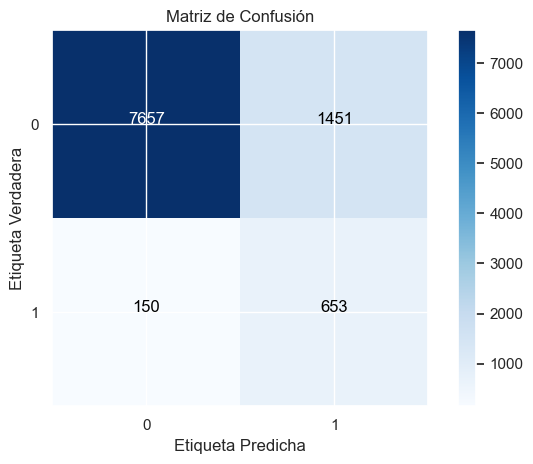

In [103]:
y_pred_test = pipe_lgbm.predict(X_test)
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
# Configura el gráfico
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()

# Añade etiquetas a los ejes
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Añade los valores de la matriz en cada celda
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

### XGBoost

In [100]:
# Modelo
model_xgb = XGBClassifier(
    # objective="binary",
    random_state=58,
    is_unbalance= True,
    max_depth=8,
    reg_alpha=100,
    n_jobs=-1,
    n_estimators=1000,
    verbose=-1,
)

# Pipeline
pipe_xgb = Pipeline([
    ("preproc", preprocessor), 
    ("model", model_xgb)
    ],
    verbose=True)

pipe_xgb.fit(X_train, y_train)


pipe_xgb

c:\Users\John\anaconda3\envs\automl\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but CorrelationThreshold was fitted without feature names
  warnings.warn(


[Pipeline] ........... (step 1 of 2) Processing preproc, total=   2.5s
[Pipeline] ............. (step 2 of 2) Processing model, total=   2.7s


Pipeline(steps=[('preproc',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(add_indicator=True,
                                                                                                  fill_value=0,
                                                                                                  strategy='constant')),
                                                                                   ('correlation_threshold',
                                                                                    CorrelationThreshold())]),
                                                                   ['lead_time',
                                                                    'stays_in_weekend_nights',
                                                                    'stays_in_week_nights',
                                                                    'adults',
                                                                    'is_repeated_guest',
                                                                    'previous_cance...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, is_unbalance=True,
                               learning_rate=None, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=1000,
                               n_jobs=-1, num_parallel_tree=None, ...))],
         verbose=True)

c:\Users\John\anaconda3\envs\automl\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but CorrelationThreshold was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.94      0.99      0.96      9108
           1       0.68      0.32      0.44       803

    accuracy                           0.93      9911
   macro avg       0.81      0.65      0.70      9911
weighted avg       0.92      0.93      0.92      9911



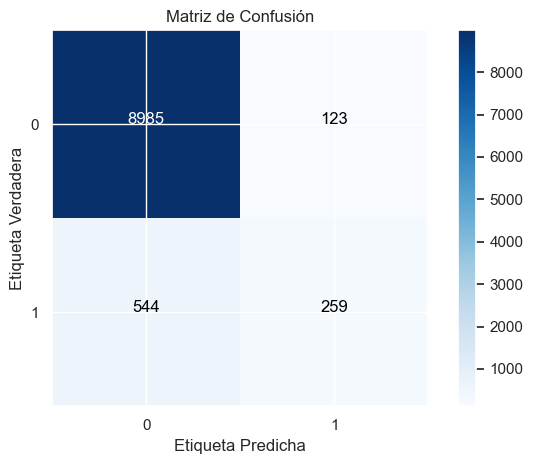

In [101]:
y_pred_test = pipe_xgb.predict(X_test)
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
# Configura el gráfico
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()

# Añade etiquetas a los ejes
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Añade los valores de la matriz en cada celda
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

### Random Forest

In [104]:

# Modelo
model_rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=58,
    max_depth=8,
    n_estimators=100,
    verbose=0,
)

# Pipeline
pipe_rf = Pipeline([
    ("preproc", preprocessor), 
    ("model", model_rf)
    ],
    verbose=True)

pipe_rf.fit(X_train, y_train)

pipe_rf

c:\Users\John\anaconda3\envs\automl\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but CorrelationThreshold was fitted without feature names
  warnings.warn(


[Pipeline] ........... (step 1 of 2) Processing preproc, total=   2.5s
[Pipeline] ............. (step 2 of 2) Processing model, total=  11.7s


Pipeline(steps=[('preproc',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(add_indicator=True,
                                                                                                  fill_value=0,
                                                                                                  strategy='constant')),
                                                                                   ('correlation_threshold',
                                                                                    CorrelationThreshold())]),
                                                                   ['lead_time',
                                                                    'stays_in_weekend_nights',
                                                                    'stays_in_week_nights',
                                                                    'adults',
                                                                    'is_repeated_guest',
                                                                    'previous_cance...
                                                                    'market_segment',
                                                                    'distribution_channel',
                                                                    'reserved_room_type',
                                                                    'assigned_room_type',
                                                                    'deposit_type',
                                                                    'customer_type',
                                                                    'required_car_parking_spaces',
                                                                    'summer_vacations']),
                                                                  ('non_num_hd',
                                                                   Pipeline(steps=[('catboostencoder',
                                                                                    CatBoostEncoder())]),
                                                                   ['country'])]))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        random_state=58))],
         verbose=True)

c:\Users\John\anaconda3\envs\automl\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but CorrelationThreshold was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9108
           1       0.34      0.75      0.47       803

    accuracy                           0.86      9911
   macro avg       0.66      0.81      0.70      9911
weighted avg       0.92      0.86      0.88      9911



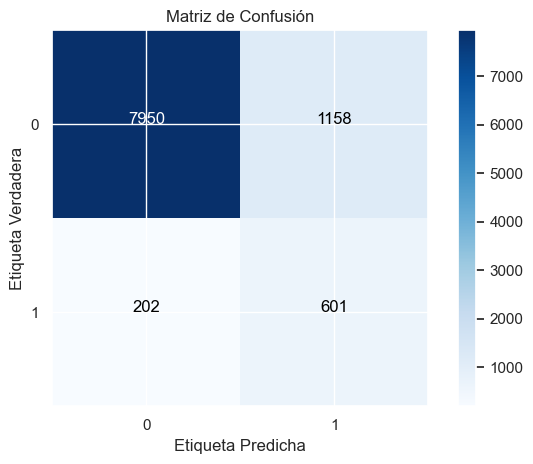

In [105]:
y_pred_test = pipe_rf.predict(X_test)
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
# Configura el gráfico
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()

# Añade etiquetas a los ejes
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Añade los valores de la matriz en cada celda
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

In [108]:
X_test_processed = preprocessor.transform(X_test)
X_test_processed

c:\Users\John\anaconda3\envs\automl\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but CorrelationThreshold was fitted without feature names
  warnings.warn(


,num__lead_time,num__stays_in_weekend_nights,num__stays_in_week_nights,num__adults,num__is_repeated_guest,num__previous_cancellations,num__previous_bookings_not_canceled,num__booking_changes,num__days_in_waiting_list,num__average_daily_rate,num__total_of_special_requests,non_num__hotel_Resort_Hotel,non_num__meal_BB,non_num__meal_HB,non_num__meal_SC,non_num__market_segment_Corporate,non_num__market_segment_Direct,non_num__market_segment_Groups,non_num__market_segment_Offline_TA/TO,non_num__market_segment_Online_TA,non_num__distribution_channel_Corporate,non_num__distribution_channel_Direct,non_num__distribution_channel_TA/TO,non_num__reserved_room_type_A,non_num__reserved_room_type_D,non_num__reserved_room_type_E,non_num__reserved_room_type_infrequent_sklearn,non_num__assigned_room_type_A,non_num__assigned_room_type_D,non_num__assigned_room_type_E,non_num__assigned_room_type_infrequent_sklearn,non_num__customer_type_Transient,non_num__customer_type_Transient-Party,non_num__required_car_parking_spaces_parking,non_num__summer_vacations_summer_vacation,non_num_hd__country
6384,33.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,90.00,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.078784
34333,9.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,97.02,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.079824
12793,26.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,75.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.078784
44807,6.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,45.00,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.082377
42923,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,104.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.108783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48106,149.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,122.04,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.086524
31984,182.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,58.20,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.090389
48723,13.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,35.00,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.082377
33535,256.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,115.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.047363


## Part III - Results & Conclusions

Insights Encontrados
* Se pudo observar que la mayor cantidad de clientes que se hospedan en los hoteles bajo estudio no tienen hijos, mientras que los clientes con hijos son cerca del 8%
*  Los clientes con hijos tienden a tener más peticiones especiales, hacen más cambios en la reserva, dejan un promedio de calificación diario superior y tienden a hospedarse en noches durante los días de semana con mayor frecuencia que aquellos huespedes que no tienen hijos.
* Durante los meses de julio y agosto en las vacaciones de verano, es donde más afluencia tienes los hoteles y la proporción de clientes con hijos aumenta durante esas fechas.

Modelos
* Se probaron 3 modelos de ensamble de árboles para tratar de predecir con base en la información disponible cuales clientes tienen hijos.
* El que obtuvo mejores resultados fue el Random Forest, para evaluarlos se utilizó la métrica f1, la cual hace una ponderación entre la precisión (el porcentaje de las veces en que el modelo logró predecir correctamente que un cliente tiene hijos) y recall (el porcentaje del total de clientes con hijos que el modelo pudo identificar). 
    * f1 Random Forest: 0.47
    * f1 LightGBM:0.45
    * f1 XGBoost: 0.44
* Se creo la variable summer_vacations para identificar a los clientes que se hospedaron durante los meses de julio y agosto ya que en esos meses existe la mayor proporción de clientes con hijos.



A continuación se presentan las variables que más influyeron en el modelo seleccionado mediante el uso de Shap Values

PermutationExplainer explainer: 9912it [41:22,  3.99it/s]                           


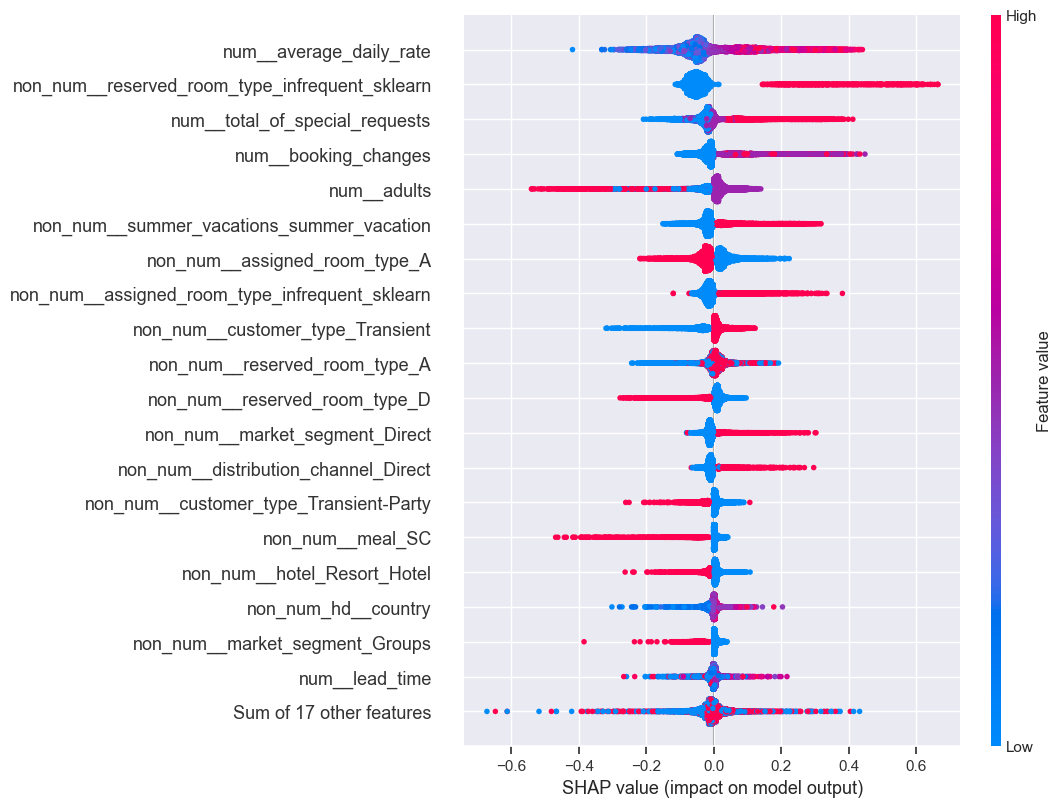

In [120]:
# Fits the explainer
explainer = shap.Explainer(pipe_rf[-1].predict, X_test_processed)
shap_values = explainer(X_test_processed)

shap.plots.beeswarm(shap_values, max_display=20)

Los valores shap se utilizan para ayudar con la interpretabilidad del modelo
* En el eje y se encuentran en orden descendente la importancia de las variables en el modelo.
* El color azul indica un valor bajo para la variable y el rojo indica un valor elevado.
* En el eje x se muestra los valores shap, valores a la derecha del cero indican que esa variable aumenta la probabilidad de que los clientes tengan hijos y valores a la izquierda indica lo contrario.

En el gráfico podemos ver lo siguiente:
* El Average Daily Rate es la variable que mejor permite identificar a los clientes con hijos, esto era de esperarse porque en gráficos anteriores se pudo observar que consistentemente estos clientes tenian valores más altos en cada uno de los meses de estudio.
* Valores elevados de Special Requests y Booking Changes también elevan la probabilidad de que el cliente tenga hijos.
* Por otro lado la cantidad de adultos en la habitación disminuyen la probabilidad de que tengan hijos y tambien el ser asignados a las habitaciones tipo A o haber reservado las habitaciones tipo D disminuyen esta probabilidad.
* La variable creada Summer Vacation tuvo el efecto esperado y eleva la probabilidad de que los clientes tengan hijos.